Prerequisites
=============

* astropy
* sncosmo
* iminuit (fitting package used by sncomso)
* Pickle files containing the lightcurves from generate_lightcurves.ipynb

In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pyplot as plt
import numpy as np
import cPickle

plt.style.use(['ggplot', 'ggplot_mod.mplstyle', 'notebooks.mplstyle'])

In [2]:
# Load from the pickle file
f = open("sne_wfd_lightcurves.pkl")
SNe_WFD_lc, SNe_WFD_truth = cPickle.load(f)
f.close()

In [10]:
first_sn = SNe_WFD_lc[SNe_WFD_lc.keys()[0]]
print("Bands:", first_sn.keys())
print("Fields: ", first_sn['i'].keys())

Bands: ['i']
Fields:  ['mjd', 'flux', 'error']


Note that the supernova lightcurves are in flux instead of magnitude. The zeropoint is defined to be zero though, so these can be converted to magnitude by $-2.5 \times \rm{log10}(\rm{flux})$

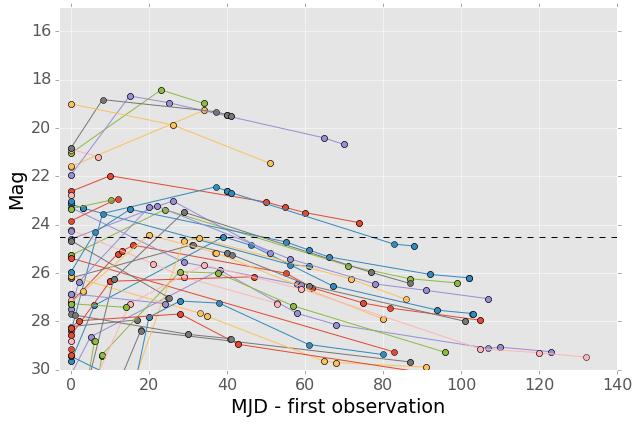

In [16]:
for id in SNe_WFD_lc.keys()[:20]:
    first_sn = SNe_WFD_lc[id]
    for band, band_data in first_sn.items():
        if len(band_data['mjd']) == 0:
            # If the light curve is empty for some reason
            continue

        plt.plot(band_data['mjd'] - min(band_data['mjd']),
                 -2.5*np.log10(band_data['flux']), 'o-')

plt.axhline(24.5, ls='--', color='k')
plt.xlim(xmin=-3)
plt.ylim(ymax=30)
plt.gca().invert_yaxis()
plt.ylabel("Mag")
plt.xlabel("MJD - first observation")

Most of these light curves are below the single band detection threshold (at about 24.5 mag). That is intentional; the examples are meant to be somewhat liberally selected, and then users can apply the selection cuts which they think are appropriate.

Note that if we had plotted the error bars on these light curves, the points below the 24.5 show extremely large error bars consistent with zero. When add this noise to the points, only the brighter objects remain distinct.

/Users/ctslater/.local/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in log10


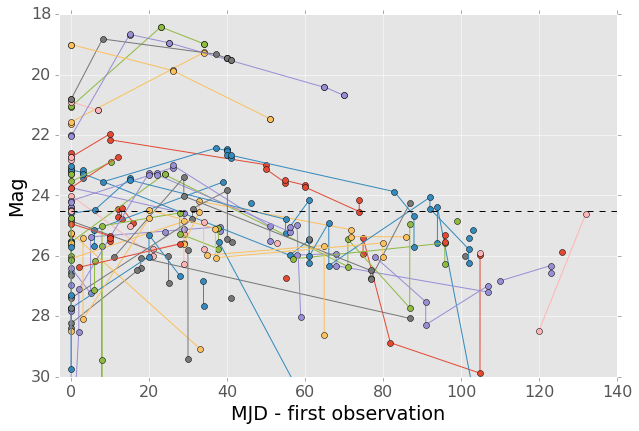

In [24]:
for id in SNe_WFD_lc.keys()[:20]:
    first_sn = SNe_WFD_lc[id]
    for band, band_data in first_sn.items():
        if len(band_data['mjd']) == 0:
            # If the light curve is empty for some reason
            continue

        #
        # This line applies random noise to each observation
        #
        sampled_flux = band_data['flux'] + np.random.normal(scale=band_data['error'])

        plt.plot(band_data['mjd'] - min(band_data['mjd']),
                 -2.5*np.log10(sampled_flux), 'o-')

plt.axhline(24.5, ls='--', color='k')
plt.xlim(xmin=-3)
plt.ylim(ymax=30)
plt.gca().invert_yaxis()
plt.ylabel("Mag")
plt.xlabel("MJD - first observation")

We can then exclude sources which were less than 5-sigma detections. In LSST, once a source does go above 5 sigma, we will perform force photometry on previous and subsequent epochs to extract these low signal to noise measurements, but that is a more detailed level of analysis than we want right now.

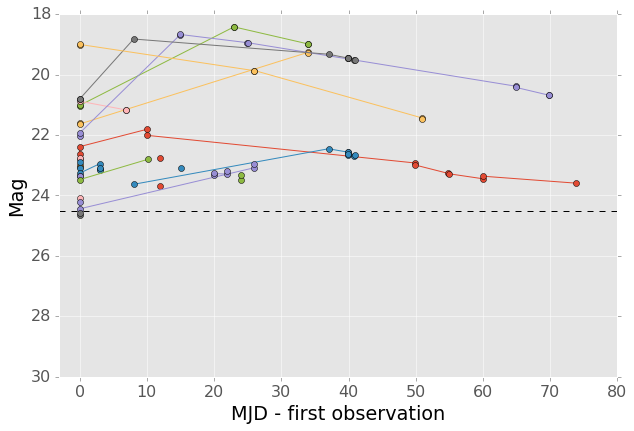

In [26]:
for id in SNe_WFD_lc.keys()[:20]:
    first_sn = SNe_WFD_lc[id]
    for band, band_data in first_sn.items():
        if len(band_data['mjd']) == 0:
            # If the light curve is empty for some reason
            continue

        #
        # This line applies random noise to each observation
        #
        sampled_flux = band_data['flux'] + np.random.normal(scale=band_data['error'])

        above_5sigma, = np.where(sampled_flux > 5*band_data['error'])
        plt.plot(band_data['mjd'][above_5sigma] - min(band_data['mjd']),
                 -2.5*np.log10(sampled_flux[above_5sigma]), 'o-')

plt.axhline(24.5, ls='--', color='k')
plt.xlim(xmin=-3)
plt.ylim(ymax=30)
plt.gca().invert_yaxis()
plt.ylabel("Mag")
plt.xlabel("MJD - first observation")

Much cleaner!

Now you can see what the sampling will look like for individual supernovae. It's a bit better than this plot, because I've shown each band as a separate line.

Possible directions from here:
* Clip out all $< 5\sigma$ detections, and histogram how many samples we get per lightcurve (possibly per band) in Wide-Fast-Deep.
* How many detections will we likely have before the peak? One can estimate the peak using the noise-free data.

Note that this set of light curves is not meant to get the exact right population statistics; it has been fudged a bit to make sure we get plenty of light curves. For this reason, it's best not to try and extract anything like a number of events per square degree from this dataset.

Deep Drilling Fields
====================

LSST will observe a handful of fields on a much more rapid cadence. These are the so-called "Deep drilling fields", and they will be particularly fruitful for supernovae. As with Wide-Fast-Deep, remember that this is just a representative cadence at the moment; further work on refining the cadence is ongoing (see, e.g., the cadence whitepaper).

In [30]:
# Load from the pickle file
f = open("sne_dd_lightcurves.pkl")
SNe_DD_lc, SNe_DD_truth = cPickle.load(f)
f.close()

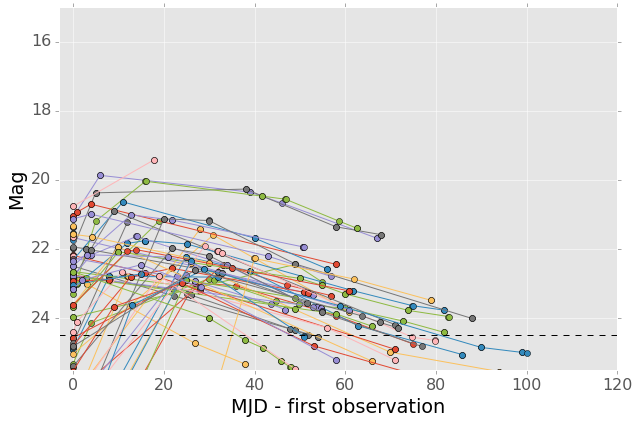

In [42]:
for id in SNe_DD_lc.keys()[:100]:
    first_sn = SNe_DD_lc[id]
    for band, band_data in first_sn.items():
        if len(band_data['mjd']) == 0:
            # If the light curve is empty for some reason
            continue
            
        mags = -2.5*np.log10(band_data['flux'])
        
        # Only show light curves that get above 23rd magnitude.
        if np.min(mags) > 23:
            continue

        plt.plot(band_data['mjd'] - min(band_data['mjd']), mags, 'o-')

plt.axhline(24.5, ls='--', color='k')
plt.xlim(xmin=-3)
plt.ylim(ymax=25.5)
plt.gca().invert_yaxis()
plt.ylabel("Mag")
plt.xlabel("MJD - first observation")